In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import RegexpTokenizer

import json

# import nltk
# nltk.download('punkt')

%matplotlib inline

In [2]:
#setting display setting large to help with visualizations of results
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Import Most Recent DataSets

In [3]:
college = pd.read_csv('./data/college_oct17')
grad_school = pd.read_csv('./data/grad_school_oct17')

In [4]:
len(college)

2885

In [5]:
print(f'There are {len(college)} threads in the /r/college subreddit')
print(f'There are {len(grad_school)} threads in the /r/GradSchool subreddit')

There are 2885 threads in the /r/college subreddit
There are 3745 threads in the /r/GradSchool subreddit


Appending the two dataframes together for further analysis (c_gs). Also creating an extra dataframe as backup (c_gs1). 

In [6]:
c_gs = college.append(grad_school)
c_gs1 = college.append(grad_school)

In [7]:
c_gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6630 entries, 0 to 3744
Data columns (total 6 columns):
title           6630 non-null object
body            5319 non-null object
num_comments    6630 non-null int64
up_votes        6630 non-null int64
age             6630 non-null float64
subreddit       6630 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 362.6+ KB


There are many posts where there was no body text. We want to replace this blank with a space to help our EDA. 

In [8]:
#replacing all Null values with a ' '
c_gs = c_gs.replace(np.nan, " ")
c_gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6630 entries, 0 to 3744
Data columns (total 6 columns):
title           6630 non-null object
body            6630 non-null object
num_comments    6630 non-null int64
up_votes        6630 non-null int64
age             6630 non-null float64
subreddit       6630 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 362.6+ KB


To help clean the data we will:

- create an _all_text_ column which combines the title & body column for each post. 
- remove all punctuation and numbers from the _all_text_ column. By doing this we can have a column of only words to analyze without any symbols or numbers getting in the way of the features
- create a _word_count_ column which will give us the word count of the newly created _all_text_ column

In [9]:
# Combining the title and body columns into one column as all_text
c_gs['all_text'] = c_gs['title'] + ' ' + c_gs['body']
c_gs = c_gs.reset_index(drop=True)

#remove punctuation and numbers
c_gs['all_text'] = c_gs['all_text'].str.replace('[^\w\s]','').str.replace('\d+', '')

#creating the word count column
c_gs['word_count'] = c_gs['all_text'].apply(lambda x: len(x.split()))
c_gs.head()

,title,body,num_comments,up_votes,age,subreddit,all_text,word_count
0,FAFSA/financial aid verification questions? Ge...,"**All questions about federal student aid, the...",458,93,49.889506,college,FAFSAfinancial aid verification questions Get ...,250
1,Do you buy the parking permits?,This is geared more towards CSUs but is it act...,0,1,0.015425,college,Do you buy the parking permits This is geared ...,76
2,Anybody else feel this way?,I’ve always been considered the “smart kid”. I...,0,1,0.022798,college,Anybody else feel this way Ive always been con...,204
3,How much partner work is there in college?,Please say none,5,1,0.043457,college,How much partner work is there in college Plea...,11
4,Is my college GPA screwed?,I need some general GPA advice. My major is Ki...,1,1,0.063608,college,Is my college GPA screwed I need some general ...,232


**Setting up Target Variable (subreddit)**: 

- if the thread is from the college subreddit, it will have an integer of 0
- if the thread is from the GradSchool subreddit, it will have an integer of 1


In [10]:
c_gs['subreddit'] = c_gs['subreddit'].map({'college': 0, 'GradSchool' : 1})
c_gs.head()

,title,body,num_comments,up_votes,age,subreddit,all_text,word_count
0,FAFSA/financial aid verification questions? Ge...,"**All questions about federal student aid, the...",458,93,49.889506,0,FAFSAfinancial aid verification questions Get ...,250
1,Do you buy the parking permits?,This is geared more towards CSUs but is it act...,0,1,0.015425,0,Do you buy the parking permits This is geared ...,76
2,Anybody else feel this way?,I’ve always been considered the “smart kid”. I...,0,1,0.022798,0,Anybody else feel this way Ive always been con...,204
3,How much partner work is there in college?,Please say none,5,1,0.043457,0,How much partner work is there in college Plea...,11
4,Is my college GPA screwed?,I need some general GPA advice. My major is Ki...,1,1,0.063608,0,Is my college GPA screwed I need some general ...,232


Before we go into more analysis, we will set up our stop words. We will use the ENGLISH_STOP_WORDS dictionary from the sklearn.feature_extraction.text library. After running the baseline model, we will add the following words into the stop_words dictionary.

- im
- id
- ive
- grad
- school
- college
- phd
- masters
- just
- like
- dont

In [11]:
eda_words = list(ENGLISH_STOP_WORDS)
eda_words+=['im', 'grad', 'school', 'id', 'ive', 'college', 'phd', 'masters', 'just', 'like', 'story', 'graduate', 'dont']

# Basic EDA

In [12]:
c_gs.head()

,title,body,num_comments,up_votes,age,subreddit,all_text,word_count
0,FAFSA/financial aid verification questions? Ge...,"**All questions about federal student aid, the...",458,93,49.889506,0,FAFSAfinancial aid verification questions Get ...,250
1,Do you buy the parking permits?,This is geared more towards CSUs but is it act...,0,1,0.015425,0,Do you buy the parking permits This is geared ...,76
2,Anybody else feel this way?,I’ve always been considered the “smart kid”. I...,0,1,0.022798,0,Anybody else feel this way Ive always been con...,204
3,How much partner work is there in college?,Please say none,5,1,0.043457,0,How much partner work is there in college Plea...,11
4,Is my college GPA screwed?,I need some general GPA advice. My major is Ki...,1,1,0.063608,0,Is my college GPA screwed I need some general ...,232


We can see that there are major outliers for upvotes, number of comments, and word count. We will make another dataframe that does not include the outleirs

In [13]:
c_gs.groupby(['subreddit']).describe().T

subreddit                     0            1
num_comments count  2885.000000  3745.000000
             mean     33.137262    15.545527
             std      77.847956    24.668716
             min       0.000000     0.000000
             25%       4.000000     3.000000
             50%      10.000000     7.000000
             75%      34.000000    18.000000
             max    1508.000000   503.000000
up_votes     count  2885.000000  3745.000000
             mean    172.696360    87.893725
             std     426.780001   158.131110
             min       0.000000     0.000000
             25%       1.000000     1.000000
             50%       3.000000     3.000000
             75%     218.000000   154.000000
             max    7713.000000  1707.000000
age          count  2885.000000  3745.000000
             mean    553.196739   515.481465
             std     698.383683   683.939959
             min       0.003957     0.029416
             25%       9.228319    20.082981
             50%     270.378593    86.003236
             75%     807.152644   862.190875
             max    3092.028697  2938.308005
word_count   count  2885.000000  3745.000000
             mean    132.806932   133.847263
             std     188.610658   173.442038
             min       1.000000     1.000000
             25%      32.000000    32.000000
             50%      83.000000    92.000000
             75%     160.000000   171.000000
             max    2600.000000  3500.000000

Creating another dataframe that focus' on the IQR of each subreddit thread. This will help us for visualization purposes'.

In [14]:
c_gs_iqr = c_gs.loc[(c_gs['num_comments'] < 75) &
                   (c_gs['up_votes'] < 100) &
                   (c_gs['word_count'] < 300)]

In [15]:
c_gs_iqr.groupby(['subreddit']).describe().T

subreddit                     0            1
num_comments count  1776.000000  2374.000000
             mean      7.823761     6.855097
             std       8.383614     8.277329
             min       0.000000     0.000000
             25%       2.000000     2.000000
             50%       5.000000     4.000000
             75%      10.000000     9.000000
             max      66.000000    72.000000
up_votes     count  1776.000000  2374.000000
             mean      3.139077     4.614575
             std       7.580577    10.501306
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       1.000000     1.000000
             75%       3.000000     4.000000
             max      93.000000    99.000000
age          count  1776.000000  2374.000000
             mean    602.189227   507.945292
             std     801.732688   748.921563
             min       0.003957     0.029416
             25%       6.226704    15.191717
             50%      16.768460    30.971755
             75%    1204.395945  1077.241332
             max    3092.028697  2938.308005
word_count   count  1776.000000  2374.000000
             mean     92.846847   105.788121
             std      70.545346    72.450446
             min       1.000000     1.000000
             25%      36.000000    48.000000
             50%      78.000000    95.500000
             75%     133.000000   152.000000
             max     297.000000   298.000000

Text(0, 0.5, 'Subreddit')

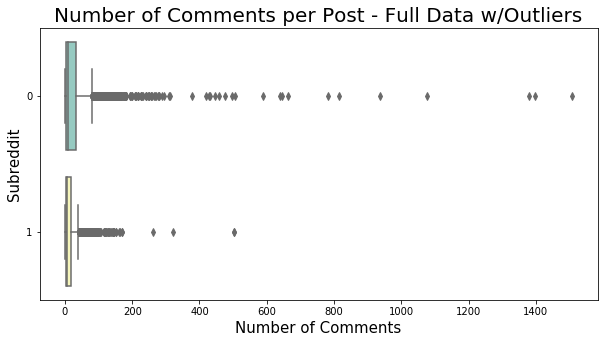

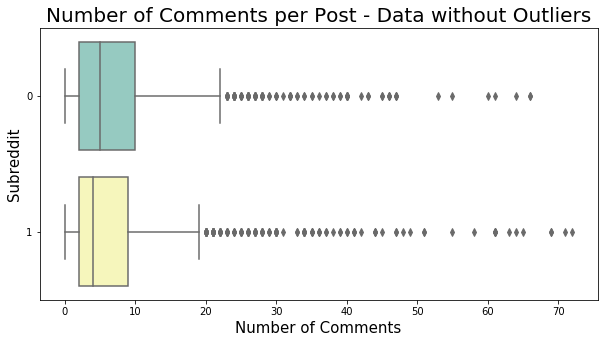

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'num_comments', y = 'subreddit', data = c_gs, orient="h", palette="Set3")
plt.title('Number of Comments per Post - Full Data w/Outliers', fontsize = 20)
plt.xlabel("Number of Comments", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'num_comments', y = 'subreddit', data = c_gs_iqr, orient="h", palette="Set3")
plt.title('Number of Comments per Post - Data without Outliers', fontsize = 20)
plt.xlabel("Number of Comments", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

Text(0, 0.5, 'Subreddit')

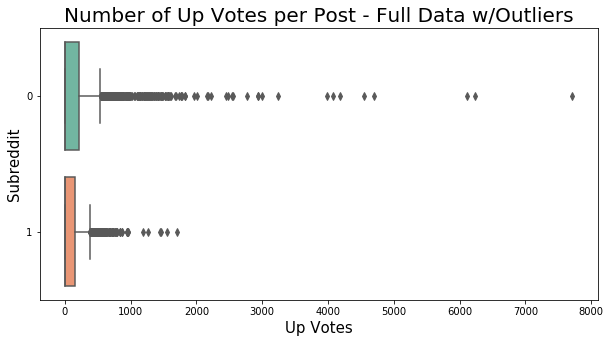

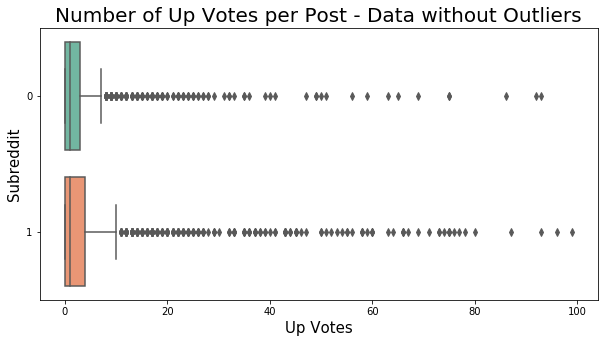

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'up_votes', y = 'subreddit', data = c_gs, orient="h", palette="Set2")
plt.title('Number of Up Votes per Post - Full Data w/Outliers', fontsize = 20)
plt.xlabel("Up Votes", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'up_votes', y = 'subreddit', data = c_gs_iqr, orient="h", palette="Set2")
plt.title('Number of Up Votes per Post - Data without Outliers', fontsize = 20)
plt.xlabel("Up Votes", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

Text(0, 0.5, 'Subreddit')

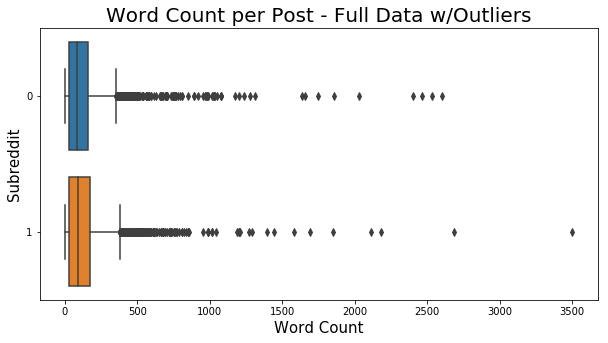

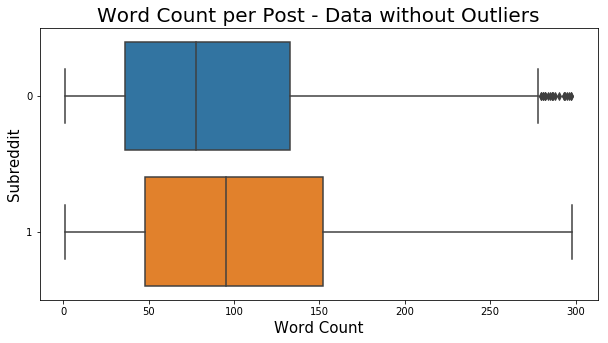

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'word_count', y = 'subreddit', data = c_gs, orient="h")
plt.title('Word Count per Post - Full Data w/Outliers', fontsize = 20)
plt.xlabel("Word Count", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'word_count', y = 'subreddit', data = c_gs_iqr, orient="h")
plt.title('Word Count per Post - Data without Outliers', fontsize = 20)
plt.xlabel("Word Count", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

After looking at the Word Count, Number of up votes, and comments per post, we can notice that the spread participation in the grad school thread is much higher than the spread of participation in the college thread. Users in the college thread do have more points lying outside the 75th percentile compared to the Grad School student. This shows me that College students are more willing to participating in bumping or upvoting on other threads compared to putting up a thread themselves. We know that there are more grad school threads compared to college threads, so we know that grad school students particpate in posting more. With their posts, they tend to have a higher word count as well. In addition, the spread of the number of comments is slightly higher than college students. This shows that grad students take more of an acitive particpation by commenting on the threads rather than upvoting

# Sentiment Analysis

We want to perform sentiment analysis to understand that "attitudes" of the threads in each subreddit. That way we can identify the language of the highly positive and highly negative threads to understand what the students struggle with and appreicate.

In [19]:
sia = SentimentIntensityAnalyzer()

In [20]:
sia_table = []
for i in c_gs['all_text']:
    sia_scores = {}
    sia_scores['sia_positive'] = sia.polarity_scores(i)['pos']
    sia_scores['sia_negative'] = sia.polarity_scores(i)['neg']
    sia_scores['sia_neutral'] = sia.polarity_scores(i)['neu']
    sia_scores['sia_compound'] = sia.polarity_scores(i)['compound']

    sia_table.append(sia_scores)
    
print (sia_table)

[{'sia_positive': 0.103, 'sia_negative': 0.007, 'sia_neutral': 0.889, 'sia_compound': 0.9623}, {'sia_positive': 0.064, 'sia_negative': 0.097, 'sia_neutral': 0.839, 'sia_compound': -0.5782}, {'sia_positive': 0.15, 'sia_negative': 0.124, 'sia_neutral': 0.726, 'sia_compound': 0.2382}, {'sia_positive': 0.187, 'sia_negative': 0.0, 'sia_neutral': 0.813, 'sia_compound': 0.3182}, {'sia_positive': 0.087, 'sia_negative': 0.174, 'sia_neutral': 0.739, 'sia_compound': -0.9717}, {'sia_positive': 0.066, 'sia_negative': 0.062, 'sia_neutral': 0.872, 'sia_compound': -0.1531}, {'sia_positive': 0.088, 'sia_negative': 0.253, 'sia_neutral': 0.659, 'sia_compound': -0.867}, {'sia_positive': 0.067, 'sia_negative': 0.023, 'sia_neutral': 0.91, 'sia_compound': 0.7181}, {'sia_positive': 0.099, 'sia_negative': 0.103, 'sia_neutral': 0.798, 'sia_compound': -0.0601}, {'sia_positive': 0.15, 'sia_negative': 0.0, 'sia_neutral': 0.85, 'sia_compound': 0.8316}, {'sia_positive': 0.151, 'sia_negative': 0.03, 'sia_neutral': 0.

I am taking some columns that were made from the original dataframe and adding it to the sia_table dataframe for further analysis

In [21]:
sia_table = pd.DataFrame(sia_table)
sia_table['subreddit'] = c_gs['subreddit']
sia_table['all_text'] = c_gs['all_text']
sia_table['word_count'] = c_gs['word_count']
sia_table['up_votes'] = c_gs['up_votes']
sia_table.head()

,sia_positive,sia_negative,sia_neutral,sia_compound,subreddit,all_text,word_count,up_votes
0,0.103,0.007,0.889,0.9623,0,FAFSAfinancial aid verification questions Get ...,250,93
1,0.064,0.097,0.839,-0.5782,0,Do you buy the parking permits This is geared ...,76,1
2,0.150,0.124,0.726,0.2382,0,Anybody else feel this way Ive always been con...,204,1
3,0.187,0.000,0.813,0.3182,0,How much partner work is there in college Plea...,11,1
4,0.087,0.174,0.739,-0.9717,0,Is my college GPA screwed I need some general ...,232,1


Some noticiable takeaways from the chart below:

- GradSchool subreddit tend to have slightly higher rated positive posts compared to College subreddit
- College subreddit has a higher IQR of negative posts but GradSchool subreddit has the highest max and mean of negative posts
- The min, max, and mean compound scores are very similar between the two threads. However, the GradSchool thread seems to have IQR that leans nowards more positive posts while the college thread IQR spreads between -0.4 to 0.8.


The GradSchool thread is more active, and nowe we notice that they are more likely to have posts that infer postivity. We will investigate more terms in the thread that appear the in more positive and negative scores

In [22]:
sia_table.groupby(['subreddit']).describe().T

subreddit                     0            1
sia_positive count  2885.000000  3745.000000
             mean      0.109072     0.113156
             std       0.094313     0.092739
             min       0.000000     0.000000
             25%       0.044000     0.051000
             50%       0.098000     0.104000
             75%       0.148000     0.155000
             max       0.787000     1.000000
sia_negative count  2885.000000  3745.000000
             mean      0.075751     0.064730
             std       0.076815     0.081856
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       0.062000     0.044000
             75%       0.114000     0.093000
             max       0.600000     0.825000
sia_neutral  count  2885.000000  3745.000000
             mean      0.815179     0.822129
             std       0.110222     0.114114
             min       0.213000     0.000000
             25%       0.756000     0.762000
             50%       0.817000     0.827000
             75%       0.880000     0.890000
             max       1.000000     1.000000
sia_compound count  2885.000000  3745.000000
             mean      0.164478     0.312810
             std       0.651136     0.612483
             min      -0.999400    -0.999600
             25%      -0.401900     0.000000
             50%       0.226300     0.460800
             75%       0.802000     0.880600
             max       0.999900     0.999800
word_count   count  2885.000000  3745.000000
             mean    132.806932   133.847263
             std     188.610658   173.442038
             min       1.000000     1.000000
             25%      32.000000    32.000000
             50%      83.000000    92.000000
             75%     160.000000   171.000000
             max    2600.000000  3500.000000
up_votes     count  2885.000000  3745.000000
             mean    172.696360    87.893725
             std     426.780001   158.131110
             min       0.000000     0.000000
             25%       1.000000     1.000000
             50%       3.000000     3.000000
             75%     218.000000   154.000000
             max    7713.000000  1707.000000

Text(0, 0.5, 'Subreddit')

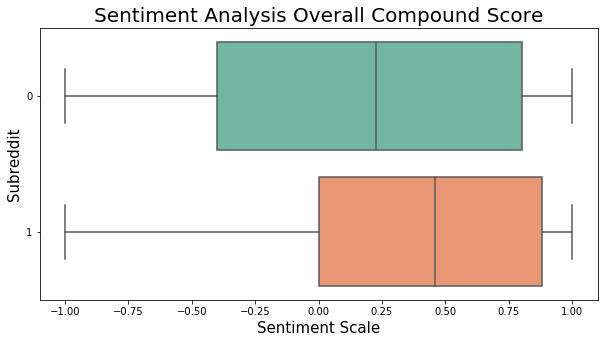

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'sia_compound', y = 'subreddit', data = sia_table, orient="h", palette="Set2")
plt.title('Sentiment Analysis Overall Compound Score', fontsize = 20)
plt.xlabel("Sentiment Scale", fontsize = 15)
plt.ylabel("Subreddit", fontsize = 15)

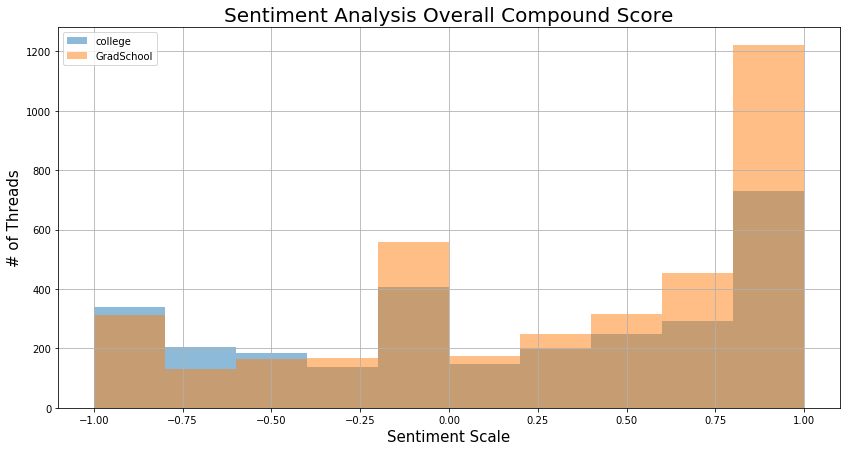

In [24]:
fig, ax = plt.subplots(1,1,figsize=(14,7))
sia_table.groupby('subreddit')['sia_compound'].hist(alpha=0.5, ax=ax,)
ax.legend(['college', 'GradSchool'])
plt.title('Sentiment Analysis Overall Compound Score', fontsize = 20)
plt.xlabel("Sentiment Scale", fontsize = 15)
plt.ylabel("# of Threads", fontsize = 15)
plt.show()

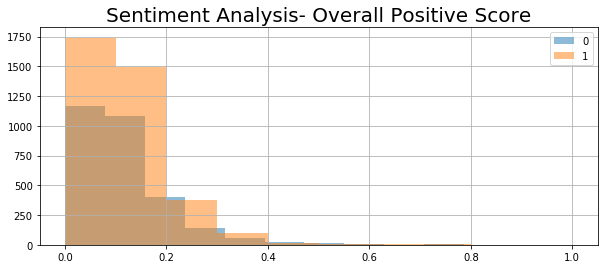

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
sia_table.groupby('subreddit')['sia_positive'].hist(alpha=0.5, ax=ax)
ax.legend(sia_table['subreddit'].unique())
plt.title('Sentiment Analysis- Overall Positive Score', fontsize = 20)
plt.show()

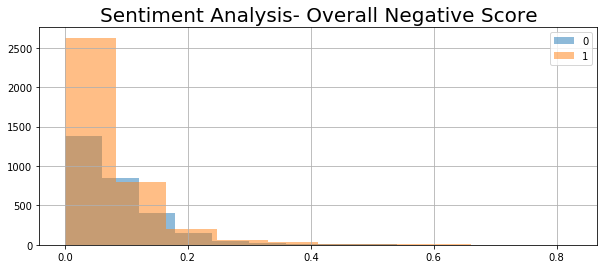

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
sia_table.groupby('subreddit')['sia_negative'].hist(alpha=0.5, ax=ax)
ax.legend(sia_table['subreddit'].unique())
plt.title('Sentiment Analysis- Overall Negative Score', fontsize = 20)
plt.show()

Appending sia_table dataframe to original c_gs dataframe for further analysis & to keep track of what information we have already looked at

In [27]:
c_gs['sia_compound'] = sia_table['sia_compound']
c_gs.head()

,title,body,num_comments,up_votes,age,subreddit,all_text,word_count,sia_compound
0,FAFSA/financial aid verification questions? Ge...,"**All questions about federal student aid, the...",458,93,49.889506,0,FAFSAfinancial aid verification questions Get ...,250,0.9623
1,Do you buy the parking permits?,This is geared more towards CSUs but is it act...,0,1,0.015425,0,Do you buy the parking permits This is geared ...,76,-0.5782
2,Anybody else feel this way?,I’ve always been considered the “smart kid”. I...,0,1,0.022798,0,Anybody else feel this way Ive always been con...,204,0.2382
3,How much partner work is there in college?,Please say none,5,1,0.043457,0,How much partner work is there in college Plea...,11,0.3182
4,Is my college GPA screwed?,I need some general GPA advice. My major is Ki...,1,1,0.063608,0,Is my college GPA screwed I need some general ...,232,-0.9717


In [28]:
c_gs_iqr['sia_compound'] = sia_table['sia_compound']

C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


I originally created the graph below to take into account all posts in the dataframe, however the spread of word count was too high and the graph was hard to read. After removing a sizable amount of Outliers, I regraphed the overall sentiment compound analysis compared to word count of each thread and sorted it by the subreddit where GradSchool = 1 and College = 0.

The organge (GradSchool) threads seem to take up more space on the right compared to the left and the blue takes up more space on the left. This shows us again that there are more GradSchool posts that lean positive.

Unfortunatley this graph doesn't give much insight into the relationship of word count and sentiment.

<Figure size 720x1440 with 0 Axes>

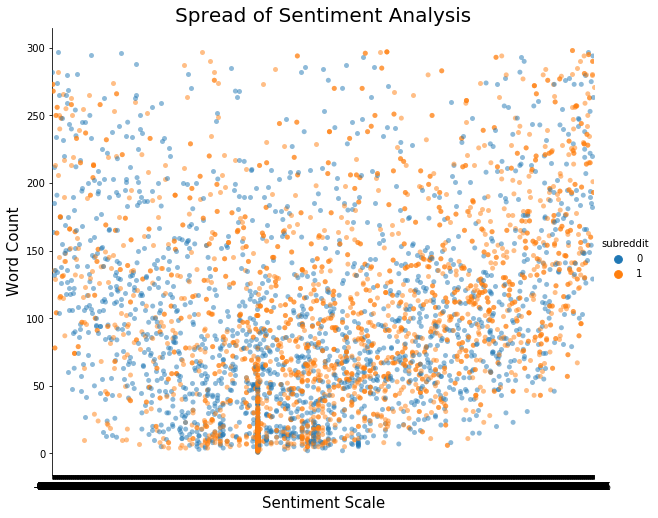

In [29]:
plt.figure(figsize = (10, 20))
sns.catplot(x = 'sia_compound', y ='word_count', hue = 'subreddit', data=c_gs_iqr, alpha = 0.5,
           height = 7, aspect = 1.2)

plt.xlabel("Sentiment Scale", fontsize = 15)
plt.ylabel("Word Count", fontsize = 15)
plt.title('Spread of Sentiment Analysis', fontsize = 20);

# Most Common Terms

In [30]:
X = c_gs['all_text']
y = c_gs['subreddit']

In [31]:
cvec = CountVectorizer(stop_words = eda_words, ngram_range = (2,2),
                       min_df = 3, max_df = .90)

common_terms = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()
)

common_terms['subreddit'] = y
common_terms.head()

,ability focus,ability make,able absorb,able answer,able apply,able ask,able assess,able attend,able better,able change,able come,able complete,able contribute,able cope,able decent,able defend,able enjoy,able finish,able focus,able good,able grade,able handle,able help,able hold,able include,able job,able junior,able land,able learn,able make,able manage,able pay,able play,able present,able pull,able record,able send,able sit,able study,able support,able things,able use,able wanted,able work,able write,abridged line,abroad does,abroad unsure,absence classes,absolute best,absolute failure,absolute forefront,absolute minimum,absolutely clue,absolutely destroyed,absolutely hate,absolutely idea,absolutely know,absolutely leave,absolutely love,absolutely loved,absolutely miserable,absolutely terrified,absolutely work,absorb work,absorbing learning,abstract accepted,abstract algebra,abstract generation,abstract trained,abstracts things,abusive relationship,academia continue,academia dislike,academia feel,academia generally,academia help,academia learning,academia probably,academia really,academia research,academia started,academia steeped,academia thats,academia think,academia tldr,academia want,academia years,academiaand wanted,academic achievement,academic advisor,academic background,academic backgrounds,academic career,academic conference,academic culture,academic excellence,academic experiences,academic history,academic honesty,academic integrity,academic job,academic life,academic madness,academic probation,academic progress,academic reading,academic record,academic research,academic resources,academic scholarship,academic setting,academic success,academic work,academic world,academic writing,academic year,academically socially,accept offer,accept role,accept student,accept time,acceptability know,acceptable ask,acceptance letter,acceptance rate,acceptance rates,accepted conference,accepted ivy,accepted kind,accepted know,accepted new,accepted offer,accepted poster,accepted pretty,accepted program,accepted programs,accepted publication,accepted revisions,accepted right,accepted spring,accepted student,accepted university,accepted week,accepted year,accepting offer,accepting students,access code,access codes,access insurance,access online,access resources,accommodate student,accomplished missing,accomplished physical,accomplishment achieve,according reviewer,account theoretical,account things,accounting class,accounting firm,accounting major,accumulated posteducation,achieve goal,achieve goals,achieve hell,achieve tenure,acknowledgement whatsoever,act sat,act score,actively doing,actively practice,actively students,actively trying,actively work,actively working,actively works,activities outside,actual classes,actual life,actual work,actually asked,actually asks,actually came,actually cried,actually diving,actually doing,actually ended,actually enjoy,actually felt,actually getting,actually going,actually good,actually got,actually help,actually helped,actually interested,actually know,actually lab,actually love,actually make,actually makes,actually mark,actually matter,actually need,actually pretty,actually read,actually real,actually really,actually related,actually remember,actually research,actually start,actually started,actually think,actually time,actually told,actually try,actually trying,actually want,actually work,actually working,actually worth,actually write,acumen interested,add class,add cvs,add new,add resume,add things,additional advice,additional funding,additional info,additional information,additional year,additional years,address schedule,adjunct office,adjunct professor,adjunct professors,adjusting city,administration refuses,administrative work,admission questions,admission really,admissions care,admissions committee,admissions committees,admissions office,admissions officers,...,year senior,year sexually,year situation,year start,year started,year starting,year stem,year stipend,year struggle,year strugglin

Create a copy of this chart for grad school and college

In [32]:
college_terms = common_terms[common_terms['subreddit'] == 0].copy()
gs_terms = common_terms[common_terms['subreddit'] == 1].copy()

In [33]:
top_15c_2terms = college_terms.iloc[:, :-1].sum().sort_values(ascending = False).head()
top_15gs_2terms = gs_terms.iloc[:, :-1].sum().sort_values(ascending = False).head()

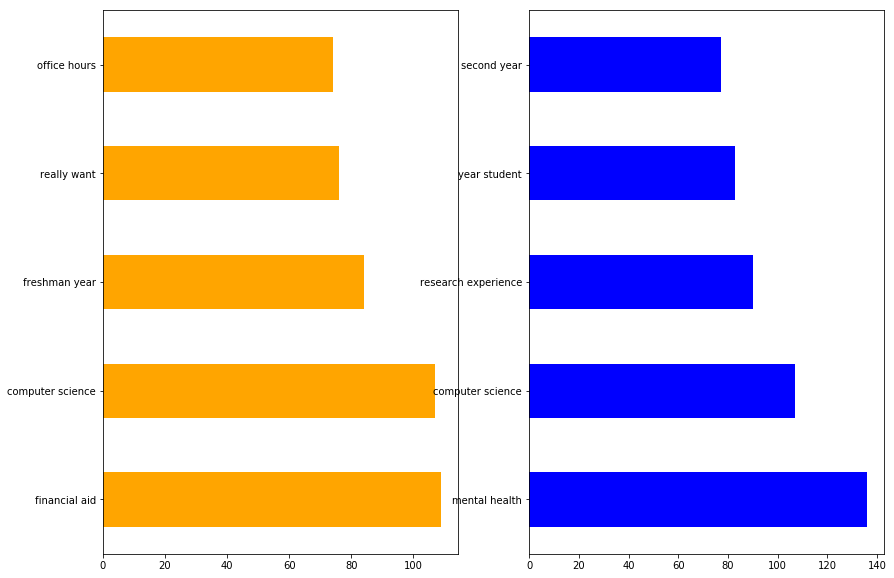

In [34]:
#looking at most commong 2-ngram terms of each thread
fig, (ax1, ax2) = plt.subplots(ncols =2, figsize=(14,10))


top_15c_2terms.T.plot.barh(ax = ax1, color = 'orange')
top_15gs_2terms.T.plot.barh(ax = ax2, color = 'blue')



### Common words 3ngram

In [35]:
cvec = CountVectorizer(stop_words = eda_words, ngram_range = (3,3),
                       min_df = 3, max_df = .90)

common_3terms = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()
)

common_3terms['subreddit'] = y
common_3terms.head()

,ability make thesis,able absorb work,able complete thesis,able contribute discussions,able focus research,able grade replacements,able include time,able junior year,able land job,able work break,abridged line believe,absence classes workshop,absolute failure thats,absolute forefront knowledge,absolutely destroyed right,absolutely know want,absolutely leave things,absolutely love bench,absolutely love researching,absolutely work started,absorb work thesis,absorbing learning material,abstract accepted poster,abstract generation bothttpswriteupairesearch,abstract trained papers,abstracts things ill,academia continue analog,academia dislike publish,academia help feel,academia learning people,academia probably isnt,academia really whats,academia started applying,academia steeped constantly,academia tldr overqualify,academia years private,academiaand wanted work,academic experiences setting,academic history book,academic job market,academic madness posted,academic madness things,academic reading note,academic year lots,accept role supervisor,accept student professor,acceptability know hell,acceptance letter choice,accepted ivy league,accepted kind refugee,accepted new offer,accepted poster presentation,accepted program really,access insurance program,accomplished missing things,accomplished physical hobby,accomplishment achieve hell,according reviewer returned,account theoretical stateoftheart,accumulated posteducation combination,achieve hell write,acknowledgement whatsoever response,actively doing research,actively practice hungarian,actively students super,actively trying better,actively work told,actively working pushes,actively works familiarize,actually asked wanted,actually diving history,actually makes sense,actually mark progress,actually research rxn,actually want quit,actually work suddenly,acumen interested wanted,add cvs wondered,additional info talking,address schedule screams,admission really cared,admit academia learning,admit science terms,admitted defeat faced,admitted defeat past,adobe illustrator endnote,adopted possibly ease,adults seen people,advanced degree continue,advantage services offered,adventure process wasnt,advice appreciated edit,advice appreciated thank,advice appreciated thanks,advice current advisor,advice firstyear student,advice getting started,advice greatly appreciated,advice half week,advice hello currently,advice hello recently,advice history major,advice issue started,advice manage time,advice navigating httpwwwopiniomicsorgtipsforphdstudentsandearlycareerresearchers,advice new students,advice proactive prevent,advice realistic going,advice really appreciate,advice related problems,advice second year,advice similar experiences,advice start gain,advice work feeling,advisor awesome actively,advisor cool despite,advisor critical career,advisor department head,advisor doesnt believe,advisor earlier today,advisor feel did,advisor finally got,advisor gave option,advisor gives option,advisor guy met,advisor initially said,advisor isnt best,advisor jerk fruitful,advisor longer need,advisor mentor officially,advisor missed obvious,advisor need advice,advisor project midway,advisor quick dismiss,advisor quit quitter,advisor said lack,advisor sure thats,advisor tell youre,advisor told years,advisor took things,advisor try screw,advisor turns assumptions,advisor want leave,advisor wasnt personable,advisor way fine,advisors care cohort,advisors months limbo,advisors students happy,affair unless want,affect chances getting,affecting anymore motivated,afford purchase makes,afraid seek counseling,afraid wont able,agencies want cosigners,ago entails week,ago feel drowning,ago going cycles,ago lecture got,ago vent ahhhhhhhhhhhhhh,agreeing stay dear,agricultural engineeringag infectious,ahead research stay,ahhhhhhhhhhh weeks biochemistry,ahhhhhhhhhhhhhh sorry needed,aimed importantly theory,aiming overqualify types,alcohol related group,algebra real analysis,algorithms hope use,allconsuming years absolutely,

In [36]:
top_15c_3terms = common_3terms[common_3terms['subreddit'] == 0].copy()
top_15gs_3terms = common_3terms[common_3terms['subreddit'] == 1].copy()

## /r/College Sentiment Analysis

Now we will look at the Sentiment analysis focus' directly on each thread. I made 2 dataframes for each subreddit. One Dataframe focus' on the threads that had a sentiment analysis compound score above 0.6 and the other had a compound score below -0.6. THis dataframe will include stop words. Without the custom stop words, there are many terms that appear mentioning "grad school" and other gramatical terms such as "i", "i've", "just like," etc. 

In [38]:
pos_c_rates = sia_table.loc[(sia_table['sia_compound'] > 0.6) & (sia_table['subreddit'] == 0)] 
neg_c_rates = sia_table.loc[(sia_table['sia_compound'] < -0.6) & (sia_table['subreddit'] == 0)]

In [39]:
pos_c_rates = pos_c_rates.reset_index(drop=True)
neg_c_rates = neg_c_rates.reset_index(drop = True)

In [55]:
print(len(pos_c_rates))
print(len(neg_c_rates))

1022
544


### Positive /r/College words 1n_gram

In [40]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (1,1), max_df = .95, min_df= 10)
pos_c_matrix = (cvec.fit_transform(pos_c_rates['all_text']))
pos_c_df = pd.DataFrame(pos_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_c_df['subreddit'] = pos_c_rates['subreddit']
pos_c_dict = {word: pos_c_df[word].sum() for word in cvec.get_feature_names()}
pos_c_df = pd.DataFrame(pos_c_dict, index = ['count'])
pos_c_df = pos_c_df.T
pos_c_df.sort_values(by='count', ascending = False).head()

,count
time,688
know,635
people,617
want,592
class,579


### Positive /r/College words 2n-gram

In [41]:
cvec = CountVectorizer(lowercase=True, stop_words= eda_words ,ngram_range = (2,2), max_df = .90, min_df= 10)
pos_c_matrix = (cvec.fit_transform(pos_c_rates['all_text']))
pos_c_df = pd.DataFrame(pos_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_c_df['subreddit'] = pos_c_rates['subreddit']
pos_c_dict = {word: pos_c_df[word].sum() for word in cvec.get_feature_names()}
pos_c_df = pd.DataFrame(pos_c_dict, index = ['count'])
pos_c_df = pos_c_df.T
pos_c_df.sort_values(by='count', ascending = False).head()

,count
financial aid,73
computer science,57
freshman year,47
make sure,43
make friends,35


### Positive /r/College words 3n-gramb

In [42]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (3,3), max_df = .90, min_df= 5)
pos_c_matrix = (cvec.fit_transform(pos_c_rates['all_text']))
pos_c_df = pd.DataFrame(pos_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_c_df['subreddit'] = pos_c_rates['subreddit']
pos_c_dict = {word: pos_c_df[word].sum() for word in cvec.get_feature_names()}
pos_c_df = pd.DataFrame(pos_c_dict, index = ['count'])
pos_c_df = pos_c_df.T
pos_c_df.sort_values(by='count', ascending = False).head()

,count
save lot time,8
computer science major,7
meet new people,7
tax information irs,6
legal electronic signature,6


The positive terms for college don't have much significance. We notice there is some talk about meeting new people and having frinds. Other terms include discussion about financial aid. I would be interesting to investigate the treads that include this term and see what they are actually talking about

### Negative /r/College words 1n-gram

In [43]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (1,1), max_df = .95, min_df= 10)
neg_c_matrix = (cvec.fit_transform(neg_c_rates['all_text']))
neg_c_df = pd.DataFrame(neg_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_c_df['subreddit'] = neg_c_rates['subreddit']
neg_c_dict = {word: neg_c_df[word].sum() for word in cvec.get_feature_names()}
neg_c_df = pd.DataFrame(neg_c_dict, index = ['count'])
neg_c_df = neg_c_df.T
neg_c_df.sort_values(by='count', ascending = False).head()

,count
class,477
know,367
time,309
want,278
feel,271


### Negative /r/College words 2n-gram

In [44]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (2,2), max_df = .95, min_df= 5)
neg_c_matrix = (cvec.fit_transform(neg_c_rates['all_text']))
neg_c_df = pd.DataFrame(neg_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_c_df['subreddit'] = neg_c_rates['subreddit']
neg_c_dict = {word: neg_c_df[word].sum() for word in cvec.get_feature_names()}
neg_c_df = pd.DataFrame(neg_c_dict, index = ['count'])
neg_c_df = neg_c_df.T
neg_c_df.sort_values(by='count', ascending = False).head()

,count
office hours,33
really want,24
computer science,22
financial aid,21
feel bad,16


### Negative /r/College words 3n-gram

In [45]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (3,3), max_df = .95, min_df= 5)
neg_c_matrix = (cvec.fit_transform(neg_c_rates['all_text']))
neg_c_df = pd.DataFrame(neg_c_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_c_df['subreddit'] = neg_c_rates['subreddit']
neg_c_dict = {word: neg_c_df[word].sum() for word in cvec.get_feature_names()}
neg_c_df = pd.DataFrame(neg_c_dict, index = ['count'])
neg_c_df = neg_c_df.T
neg_c_df.sort_values(by='count', ascending = False)

,count
professors office hours,5


One takeaway from the college Negative words is that there seems to be a lot of talk around financial aid and offie hours.

## /r/GradSchool Sentiment Analysis

In [46]:
pos_gc_rates = sia_table.loc[(sia_table['sia_compound'] > 0.6) & (sia_table['subreddit'] == 1)] 
neg_gc_rates = sia_table.loc[(sia_table['sia_compound'] < -0.6) & (sia_table['subreddit'] == 1)] 

In [47]:
pos_gc_rates = pos_gc_rates.reset_index(drop = True)
neg_gc_rates = neg_gc_rates.reset_index(drop = True)

In [56]:
print(len(pos_gc_rates))
print(len(neg_gc_rates))

1674
442


### Positive /r/GradSchool words 1n-gram

In [48]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (1,1), max_df = .95, min_df= 5)
pos_gc_matrix = (cvec.fit_transform(pos_gc_rates['all_text']))
pos_gc_df = pd.DataFrame(pos_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_gc_df['subreddit'] = pos_gc_rates['subreddit']
pos_gc_dict = {word: pos_gc_df[word].sum() for word in cvec.get_feature_names()}
pos_gc_df = pd.DataFrame(pos_gc_dict, index = ['count'])
pos_gc_df = pos_gc_df.T
pos_gc_df.sort_values(by='count', ascending = False).head()

,count
subreddit,1674
work,991
research,948
time,937
program,907


### Positive /r/GradSchool words 2n-gram

In [49]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (2,2), max_df = .95, min_df= 5)
pos_gc_matrix = (cvec.fit_transform(pos_gc_rates['all_text']))
pos_gc_df = pd.DataFrame(pos_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_gc_df['subreddit'] = pos_gc_rates['subreddit']
pos_gc_dict = {word: pos_gc_df[word].sum() for word in cvec.get_feature_names()}
pos_gc_df = pd.DataFrame(pos_gc_dict, index = ['count'])
pos_gc_df = pos_gc_df.T
pos_gc_df.sort_values(by='count', ascending = False).head()

,count
mental health,72
computer science,71
research experience,57
greatly appreciated,46
make sure,44


### Positive /r/GradSchool words 3n-gram

In [50]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (3,3), max_df = .95, min_df= 5)
pos_gc_matrix = (cvec.fit_transform(pos_gc_rates['all_text']))
pos_gc_df = pd.DataFrame(pos_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
pos_gc_df['subreddit'] = pos_gc_rates['subreddit']
pos_gc_dict = {word: pos_gc_df[word].sum() for word in cvec.get_feature_names()}
pos_gc_df = pd.DataFrame(pos_gc_dict, index = ['count'])
pos_gc_df = pos_gc_df.T
pos_gc_df.sort_values(by='count', ascending = False).head()

,count
good happened week,20
advice greatly appreciated,14
years work experience,13
happened week did,11
talk good happened,10


In the GradSchool Thread, th postive terms seem to focus on mental health and there is discussion among the users on good things that happened to themselves. THis shows me that they are going on reddit to express and shre things that are happening to them.

### Negative /r/GradSchool words 1n-gram

In [51]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (1,1), max_df = .95, min_df= 5)
neg_gc_matrix = (cvec.fit_transform(neg_gc_rates['all_text']))
neg_gc_df = pd.DataFrame(neg_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_gc_df['subreddit'] = neg_gc_rates['subreddit']
neg_gc_dict = {word: neg_gc_df[word].sum() for word in cvec.get_feature_names()}
neg_gc_df = pd.DataFrame(neg_gc_dict, index = ['count'])
neg_gc_df = neg_gc_df.T
neg_gc_df.sort_values(by='count', ascending = False).head()

,count
subreddit,442
feel,340
time,310
work,287
know,276


### Negative /r/GradSchool words 2n-gram

In [52]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (2,2), max_df = .95, min_df= 5)
neg_gc_matrix = (cvec.fit_transform(neg_gc_rates['all_text']))
neg_gc_df = pd.DataFrame(neg_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_gc_df['subreddit'] = neg_gc_rates['subreddit']
neg_gc_dict = {word: neg_gc_df[word].sum() for word in cvec.get_feature_names()}
neg_gc_df = pd.DataFrame(neg_gc_dict, index = ['count'])
neg_gc_df = neg_gc_df.T
neg_gc_df.sort_values(by='count', ascending = False).head()

,count
mental health,51
years ago,22
imposter syndrome,17
really know,16
hard time,15


### Negative /r/GradSchool words 3n-gram

In [53]:
cvec = CountVectorizer (lowercase=True, stop_words= eda_words ,ngram_range = (3,3), max_df = .95, min_df= 5)
neg_gc_matrix = (cvec.fit_transform(neg_gc_rates['all_text']))
neg_gc_df = pd.DataFrame(neg_gc_matrix.toarray(),
                        columns = cvec.get_feature_names())
neg_gc_df['subreddit'] = neg_gc_rates['subreddit']
neg_gc_dict = {word: neg_gc_df[word].sum() for word in cvec.get_feature_names()}
neg_gc_df = pd.DataFrame(neg_gc_dict, index = ['count'])
neg_gc_df = neg_gc_df.T
neg_gc_df.sort_values(by='count', ascending = False).head()

,count
high blood pressure,9
having hard time,8
mental health crisis,6
mental health problems,5
really really bad,5


The negative terms that appear for grad school is quite significant. Similar to their positive terms, it seems like thenegative terms are coming from users who are sharing things that are happening to themselves. There is alot of talk on mental health and it seems like grad school  students are struggling with confidence in grad school